# EDA

**Goal** : Discover High-level patterns, trends, & relationships in the data

Questions:
- What is the overall biz trends?
- How do reviews relate to delivery performance?
- Geographic patterns?
- Which Product Categoreis performing the best?
- What areas need deeper analysis?


In [1]:
# Setup & Imports 

import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 100)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Fig Setting
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Db connection
conn = sqlite3.connect('../data/ecommerce.db')
print("Connected to SQLite database")

Connected to SQLite database


### 1. Orders Over Time

Monthly order trends:


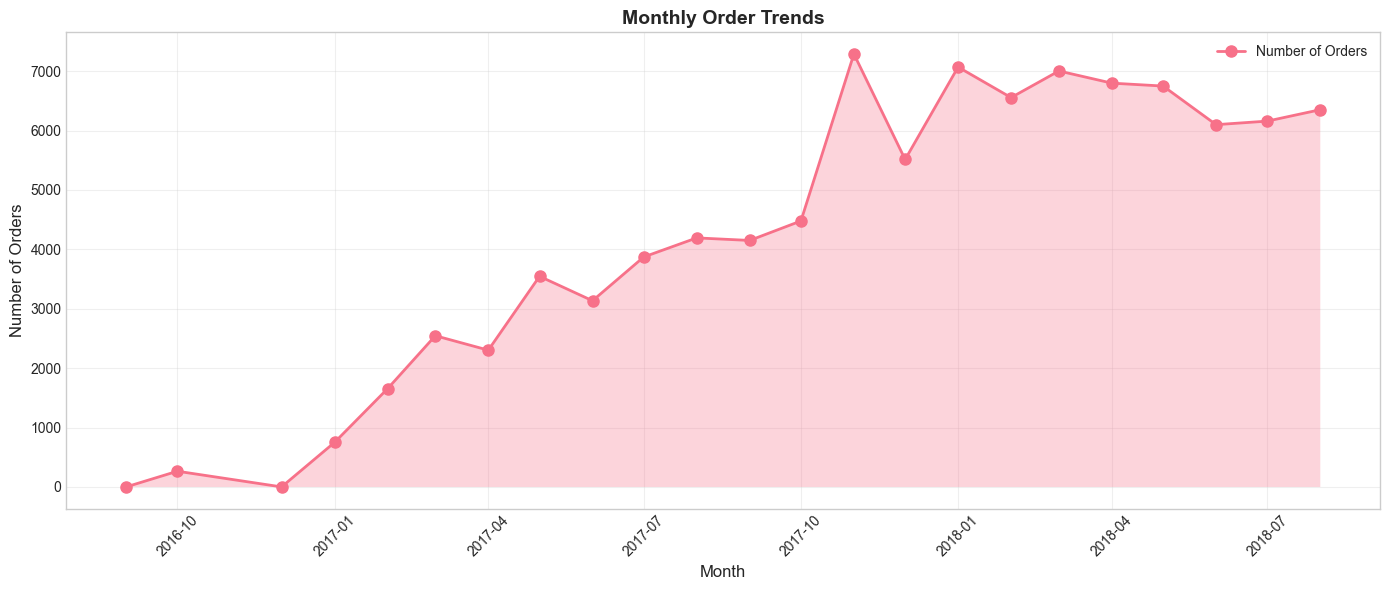


Monthly growth rates:
Average: 4613.79%
Peak Month: 2017-11
Peak orders: 7,289


In [3]:
# Monthly Order Trends

monthly_query = """
SELECT
    strftime('%Y-%m', order_purchase_timestamp) as month,
    COUNT(*) as num_orders,
    COUNT(DISTINCT customer_id) as unique_customers
FROM orders
WHERE order_status = 'delivered'
GROUP BY month
ORDER BY month;
"""

monthly_orders = pd.read_sql(monthly_query, conn)
monthly_orders['month'] = pd.to_datetime(monthly_orders['month'])
print("Monthly order trends:")
monthly_orders.head(10)

# Visuals

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(monthly_orders['month'], monthly_orders['num_orders'], marker='o', 
        linewidth=2, markersize=8, label='Number of Orders')
ax.fill_between(monthly_orders['month'], monthly_orders['num_orders'], alpha=0.3)

ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Number of Orders', fontsize=12)
ax.set_title('Monthly Order Trends', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../reports/figures/monthly_order_trends.png', dpi=300)
plt.show()

# Growth Rate

monthly_orders['growth_rate'] = monthly_orders['num_orders'].pct_change() * 100
print("\nMonthly growth rates:")
print(f"Average: {monthly_orders['growth_rate'].mean():.2f}%")
print(f"Peak Month: {monthly_orders.loc[monthly_orders['num_orders'].idxmax(), 'month'].strftime('%Y-%m')}")
print(f"Peak orders: {monthly_orders['num_orders'].max():,}")

#### 2. Day of Week & Hours - Pattern

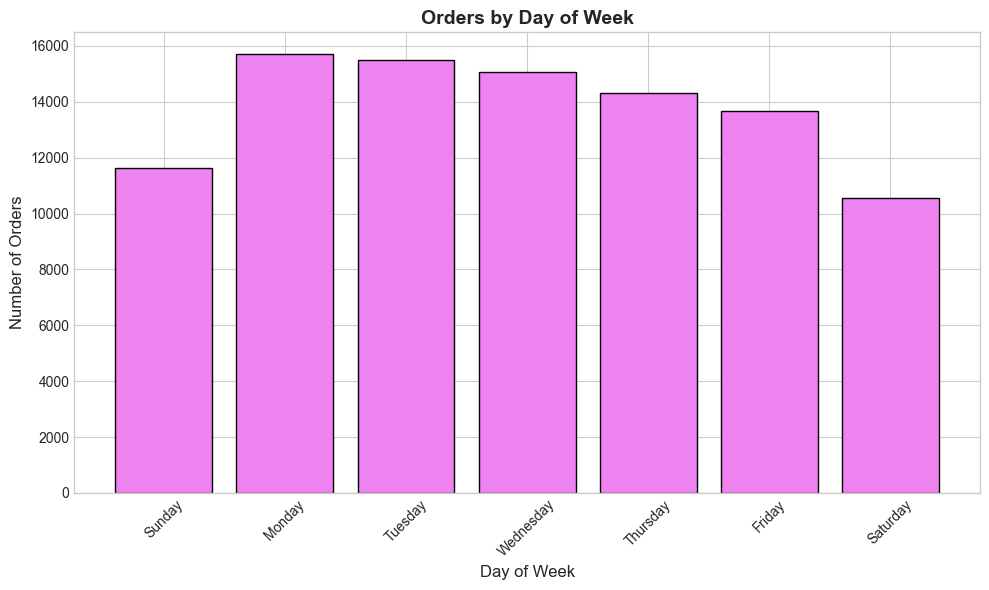

In [5]:
day_of_week_query = """
SELECT 
    CASE CAST(strftime('%w', order_purchase_timestamp) AS INTEGER)
        WHEN 0 THEN 'Sunday'
        WHEN 1 THEN 'Monday'
        WHEN 2 THEN 'Tuesday'
        WHEN 3 THEN 'Wednesday'
        WHEN 4 THEN 'Thursday'
        WHEN 5 THEN 'Friday'
        WHEN 6 THEN 'Saturday'
    END as day_of_week,
    CAST(strftime('%w', order_purchase_timestamp) AS INTEGER) as day_num,
    COUNT(*) as num_orders
FROM orders
WHERE order_status = 'delivered'
GROUP BY day_of_week, day_num
ORDER BY day_num
"""

day_of_week_query = pd.read_sql(day_of_week_query, conn)

# Visualize
plt.figure(figsize=(10, 6))
plt.bar(day_of_week_query['day_of_week'], day_of_week_query['num_orders'], color='violet', edgecolor='black')
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)
plt.title('Orders by Day of Week', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../reports/figures/orders_by_dow.png', dpi=300, bbox_inches='tight')
plt.show()

#### 3. Delivery Delay Distribution


Total orders analyzed: 95,824

Delivery Statistics:
       actual_delivery_days  delivery_delay_days
count          95824.000000         95824.000000
mean              12.516765           -11.215213
std                9.460505            10.114097
min                0.533414          -146.016123
25%                6.757214           -16.248435
50%               10.206059           -11.973050
75%               15.663542            -6.407182
max              208.351759           188.975081

Delivery Performance:
On-time deliveries: 88,163 (92.01%)
Delayed deliveries: 7,661 (7.99%)


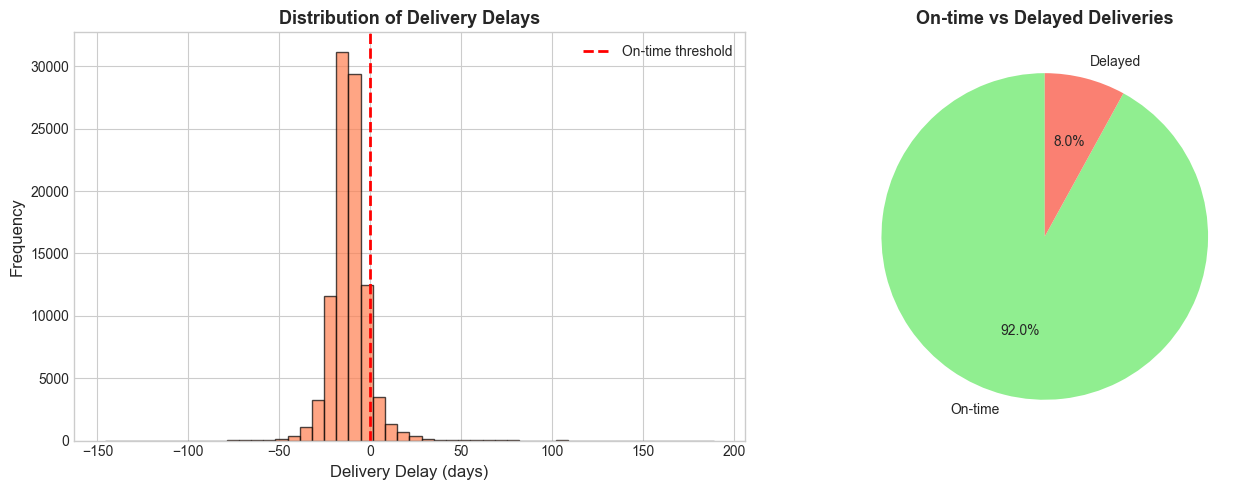

In [8]:
# Delivery Metrics from View
delivery_query = """
SELECT 
    actual_delivery_days,
    estimated_delivery_days,
    delivery_delay_days,
    is_delayed,
    review_score
FROM order_analysis
WHERE order_status = 'delivered'
  AND actual_delivery_days IS NOT NULL
  AND review_score IS NOT NULL
"""

delivery_df = pd.read_sql(delivery_query, conn)

print(f"\nTotal orders analyzed: {len(delivery_df):,}")
print(f"\nDelivery Statistics:")
print(delivery_df[['actual_delivery_days', 'delivery_delay_days']].describe())

# On-time vs delayed
delay_summary = delivery_df.groupby('is_delayed').size()
delay_pct = (delay_summary / len(delivery_df) * 100).round(2)

print("\nDelivery Performance:")
print(f"On-time deliveries: {delay_summary[0]:,} ({delay_pct[0]}%)")
print(f"Delayed deliveries: {delay_summary[1]:,} ({delay_pct[1]}%)")\


# Visualize delivery performance

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of delivery delays
axes[0].hist(delivery_df['delivery_delay_days'], bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[0].axvline(0, color='red', linestyle='--', linewidth=2, label='On-time threshold')
axes[0].set_xlabel('Delivery Delay (days)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Delivery Delays', fontsize=13, fontweight='bold')
axes[0].legend()

# Pie chart: on-time vs delayed
axes[1].pie([delay_summary[0], delay_summary[1]], 
            labels=['On-time', 'Delayed'],
            autopct='%1.1f%%',
            colors=['lightgreen', 'salmon'],
            startangle=90)
axes[1].set_title('On-time vs Delayed Deliveries', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/figures/delivery_performance.png', dpi=300, bbox_inches='tight')
plt.show()

### 4. Delay Impact on Reviews (Main INSIGHT)


Average Review Score by Delivery Status:
         mean  count
On-time  4.29  88163
Delayed  2.56   7661

Impact of delays: 1.73 stars difference!

Review Score Distribution by Delivery Status:
              count  mean   std  min  25%  50%  75%  max
is_delayed                                              
0           88163.0  4.29  1.15  1.0  4.0  5.0  5.0  5.0
1            7661.0  2.56  1.66  1.0  1.0  2.0  4.0  5.0




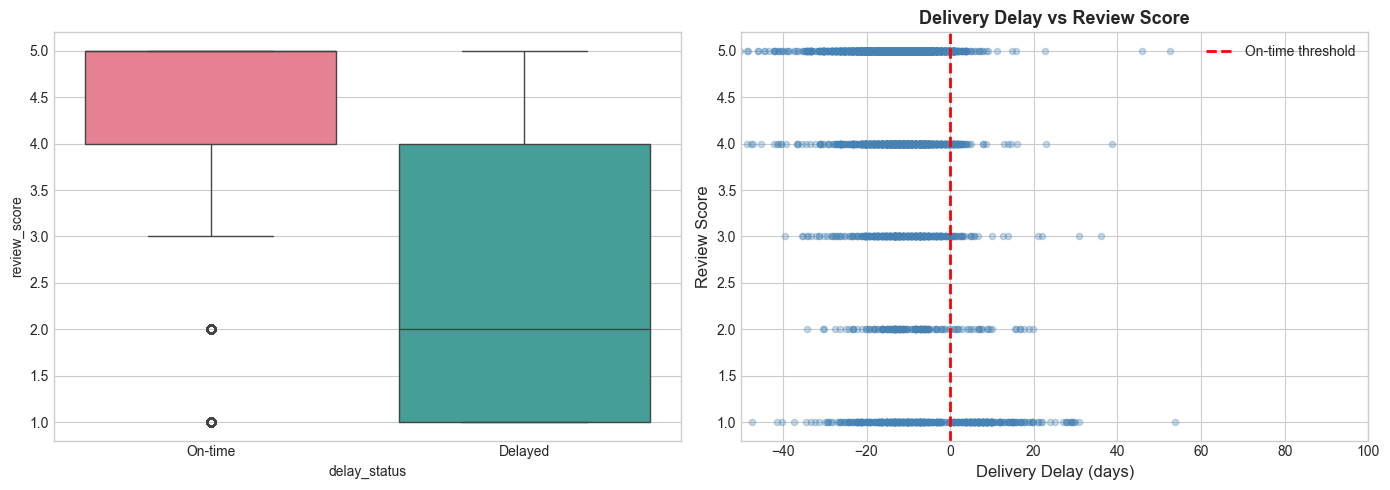

In [15]:
review_by_delay = delivery_df.groupby('is_delayed')['review_score'].agg(['mean', 'count']).round(2)
review_by_delay.index = ['On-time', 'Delayed']

print("\nAverage Review Score by Delivery Status:")
print(review_by_delay)

# Calculate the impact
impact = review_by_delay.loc['On-time', 'mean'] - review_by_delay.loc['Delayed', 'mean']
print(f"\nImpact of delays: {impact:.2f} stars difference!")

print("\nReview Score Distribution by Delivery Status:")
print(delivery_df.groupby('is_delayed')['review_score'].describe().round(2))
print("\n")
# Visualize review scores by delay status
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

delivery_df['delay_status'] = delivery_df['is_delayed'].map({0: 'On-time', 1: 'Delayed'})
sns.boxplot(data=delivery_df, x='delay_status', y='review_score', ax=axes[0], hue='delay_status', dodge=False, palette='husl')

if axes[0].get_legend() is not None:
    axes[0].get_legend().remove()
    axes[0].set_xlabel('Delivery Status', fontsize=12)
    axes[0].set_ylabel('Review Score', fontsize=12)
    axes[0].set_title('Review Scores: On-time vs Delayed', fontsize=13, fontweight='bold')

# Scatter: delay days vs review score - Sample for performance
sample = delivery_df.sample(min(5000, len(delivery_df)), random_state=42)
axes[1].scatter(sample['delivery_delay_days'], sample['review_score'], 
                alpha=0.3, s=20, color='steelblue')
axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='On-time threshold')
axes[1].set_xlabel('Delivery Delay (days)', fontsize=12)
axes[1].set_ylabel('Review Score', fontsize=12)
axes[1].set_title('Delivery Delay vs Review Score', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].set_xlim(-50, 100)

plt.tight_layout()
plt.savefig('../reports/figures/delay_vs_reviews.png', dpi=300, bbox_inches='tight')
plt.show()

#### 5. Geo Analysis


Top states by number of orders:
  customer_state  num_orders  avg_order_value  total_revenue  avg_review  avg_delivery_delay  \
0             SP       40501           143.19     5799283.95        4.24              -10.38   
1             RJ       12350           167.09     2063593.64        3.96              -11.05   
2             MG       11354           160.87     1826486.53        4.19              -12.54   
3             RS        5345           162.00      865877.26        4.18              -13.21   
4             PR        4923           159.47      785095.06        4.24              -12.62   
5             SC        3546           168.38      597067.83        4.13              -10.80   
6             BA        3256           182.25      593408.37        3.93              -10.10   
7             DF        2080           167.60      348601.41        4.13              -11.34   
8             ES        1995           159.63      318466.51        4.08               -9.80   
9      

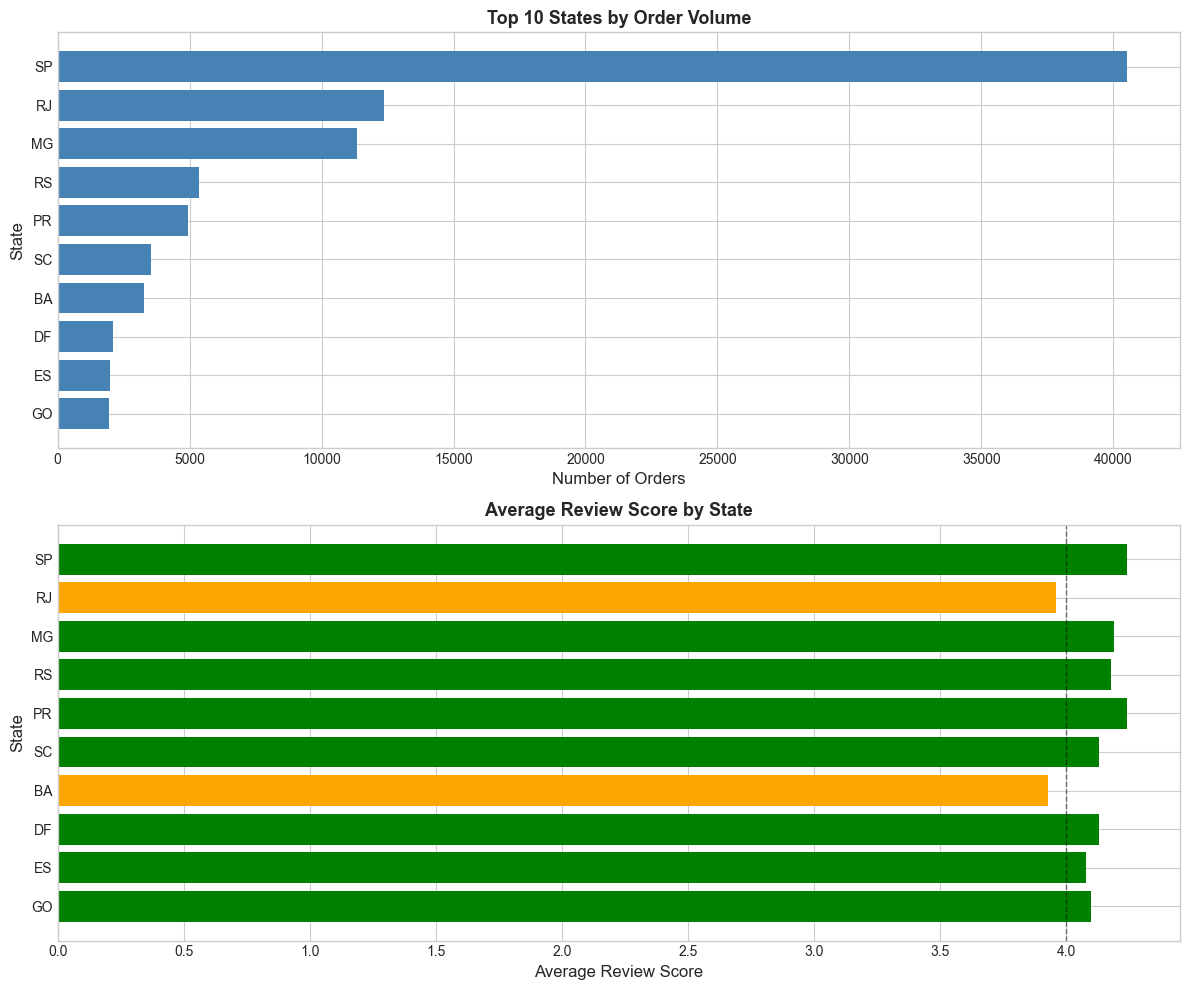

In [ ]:
geo_query = """
SELECT
        customer_state,
        COUNT(*) as num_orders,
        ROUND(AVG(total_order_value), 2) as avg_order_value,
        ROUND(SUM(total_order_value), 2) as total_revenue,
        ROUND(AVG(review_score), 2) as avg_review,
        ROUND(AVG(delivery_delay_days), 2) as avg_delivery_delay,
        ROUND(SUM(is_delayed) * 100.0 / COUNT(*), 2) as delay_rate
FROM order_analysis
WHERE order_status = 'delivered'
    AND customer_state IS NOT NULL
    AND total_order_value IS NOT NULL
GROUP BY customer_state
HAVING num_orders >= 100
ORDER BY num_orders DESC
"""

geo_df = pd.read_sql(geo_query, conn)
print("\nTop states by number of orders:")
print(geo_df.head(10))

# Visualize top states by number of orders
top_10_states = geo_df.head(10)
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# order by state
axes[0].barh(top_10_states['customer_state'], top_10_states['num_orders'], color='steelblue')
axes[0].set_xlabel('Number of Orders', fontsize=12)
axes[0].set_ylabel('State', fontsize=12)
axes[0].set_title('Top 10 States by Order Volume', fontsize=13, fontweight='bold')
axes[0].invert_yaxis()

# Avg Review Score by State
colors = ['green' if x >= 4 else 'orange' if x >= 3.5 else 'red' for x in top_10_states['avg_review']]
axes[1].barh(top_10_states['customer_state'], top_10_states['avg_review'], color=colors)
axes[1].set_xlabel('Average Review Score', fontsize=12)
axes[1].set_ylabel('State', fontsize=12)
axes[1].set_title('Average Review Score by State', fontsize=13, fontweight='bold')
axes[1].axvline(4.0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('../reports/figures/geographic_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

#### 6. Top Product Category

In [25]:
# Top Product Categories

product_query = """
SELECT
    COALESCE(pct.product_category_name_english, p.product_category_name, 'Unknown') as category,
    COUNT(DISTINCT oi.order_id) as num_orders,
    ROUND(AVG(oi.price), 2) as avg_price,
    ROUND(SUM(oi.price), 2) as total_revenue,
    ROUND(AVG(r.review_score), 2) as avg_review
FROM order_items oi
JOIN products p ON oi.product_id = p.product_id
LEFT JOIN product_category_name_translation pct ON p.product_category_name = pct.product_category_name
JOIN ORDERS o ON oi.order_id = o.order_id
LEFT JOIN order_reviews r ON o.order_id = r.order_id
WHERE o.order_status = 'delivered'
GROUP BY category
HAVING num_orders >= 100
ORDER BY total_revenue DESC
LIMIT 20
"""

product_df = pd.read_sql(product_query, conn)
print("\nTop 20 product categories by revenue:")
product_df



Top 20 product categories by revenue:


,category,num_orders,avg_price,total_revenue,avg_review
0,health_beauty,8647,130.00,1237439.95,4.19
1,watches_gifts,5495,198.88,1167246.63,4.07
2,bed_bath_table,9272,93.38,1037177.69,3.92
3,sports_leisure,7530,113.11,960189.09,4.17
4,computers_accessories,6530,116.27,896243.28,3.98
5,furniture_decor,6307,87.19,718344.78,3.95
6,housewares,5743,90.61,617836.73,4.11
7,cool_stuff,3559,164.23,612071.86,4.19
8,auto,3810,139.55,580263.44,4.12
9,toys,3804,116.92,472109.78,4.21


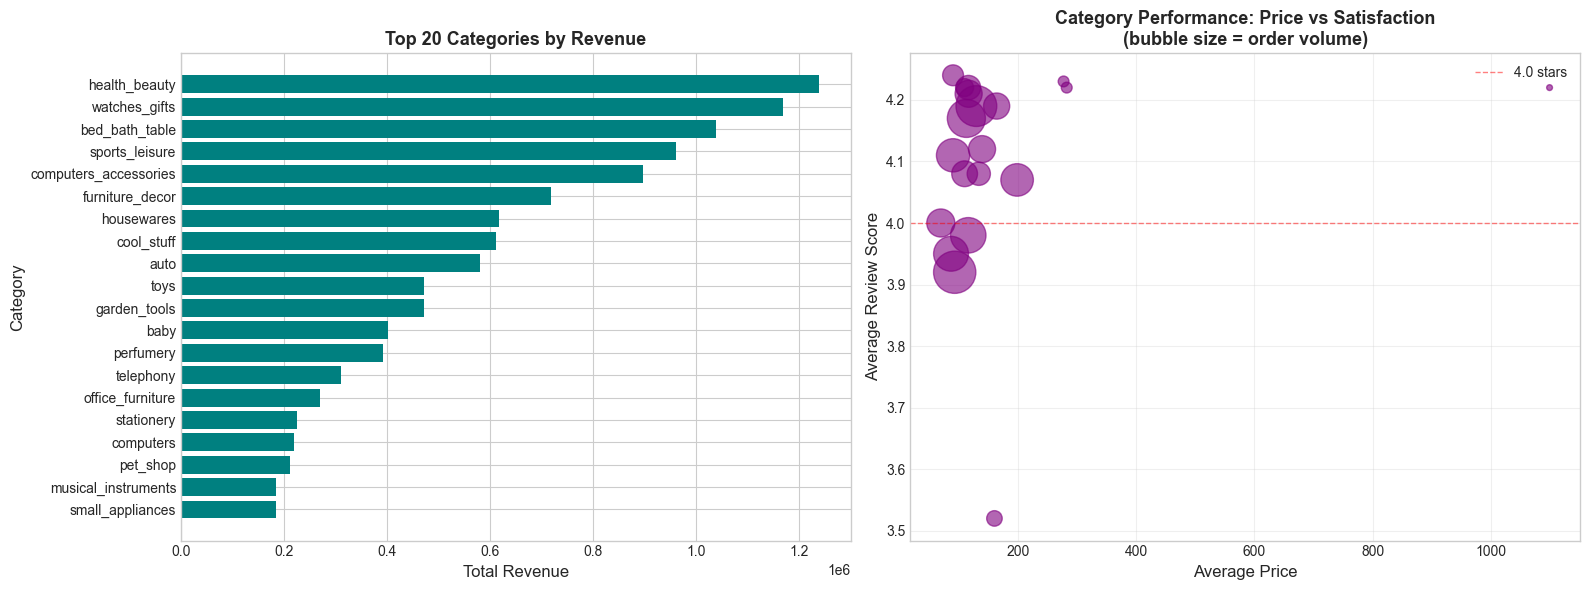

In [27]:
# Category performance visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top categories by revenue
top_cats = product_df.head(20)
axes[0].barh(top_cats['category'], top_cats['total_revenue'], color='teal')
axes[0].set_xlabel('Total Revenue', fontsize=12)
axes[0].set_ylabel('Category', fontsize=12)
axes[0].set_title('Top 20 Categories by Revenue', fontsize=13, fontweight='bold')
axes[0].invert_yaxis()

# Category satisfaction (avg price vs avg review)
axes[1].scatter(product_df['avg_price'], product_df['avg_review'], 
                s=product_df['num_orders']/10, alpha=0.6, color='purple')
axes[1].set_xlabel('Average Price', fontsize=12)
axes[1].set_ylabel('Average Review Score', fontsize=12)
axes[1].set_title('Category Performance: Price vs Satisfaction\n(bubble size = order volume)', 
                  fontsize=13, fontweight='bold')
axes[1].axhline(4.0, color='red', linestyle='--', linewidth=1, alpha=0.5, label='4.0 stars')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/category_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

#### 7. Order Value Analysis

Order Value Statistics:
count    98666.000000
mean       161.310607
std        221.293040
min          9.590000
25%         62.150000
50%        105.665000
75%        177.490000
max      13664.080000
Name: total_order_value, dtype: float64


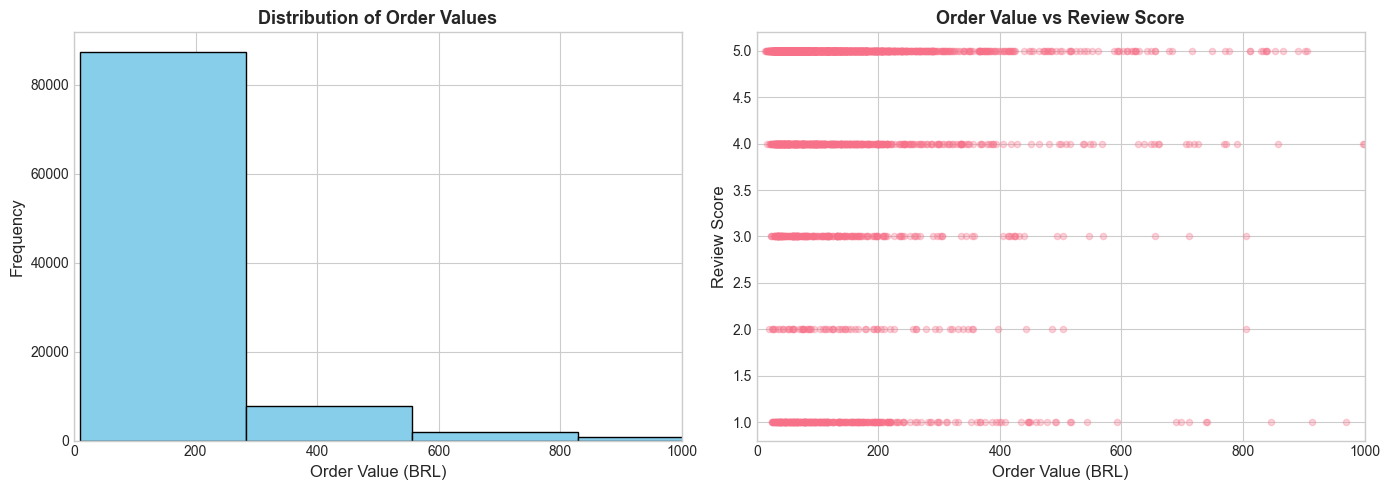

In [30]:
# Order value distribution
value_query = "SELECT " \
"total_order_value, review_score " \
"FROM order_analysis " \
"WHERE total_order_value IS NOT NULL"

value_df = pd.read_sql(value_query, conn)

print("Order Value Statistics:")
print(value_df['total_order_value'].describe())


# Visualize order value distribution

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(value_df['total_order_value'], bins=50, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Order Value (BRL)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Order Values', fontsize=13, fontweight='bold')
axes[0].set_xlim(0, 1000)  # Focus on main range

# Value vs review
sample = value_df.sample(min(3000, len(value_df)), random_state=42)
axes[1].scatter(sample['total_order_value'], sample['review_score'], alpha=0.3, s=20)
axes[1].set_xlabel('Order Value (BRL)', fontsize=12)
axes[1].set_ylabel('Review Score', fontsize=12)
axes[1].set_title('Order Value vs Review Score', fontsize=13, fontweight='bold')
axes[1].set_xlim(0, 1000)

plt.tight_layout()
plt.savefig('../reports/figures/order_value_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

#### 8. Summary - Key Insights

In [33]:
print("*" * 70)
print("KEY EXPLORATORY FINDINGS")
print("*" * 70)

print("\n📊 TEMPORAL PATTERNS:")
print(f"  • Peak month: {monthly_orders.loc[monthly_orders['num_orders'].idxmax(), 'month'].strftime('%B %Y')}")
print(f"  • Orders growing over time (investigate seasonality in notebook 03)")

print("\n🚚 DELIVERY PERFORMANCE:")
print(f"  • {delay_pct[0]:.1f}% on-time, {delay_pct[1]:.1f}% delayed")
print(f"  • Delayed orders score {impact:.2f} stars LOWER")
print(f"  • Delivery is a MAJOR factor in satisfaction!")

print("\n🌎 GEOGRAPHIC INSIGHTS:")
print(f"  • SP state dominates: {geo_df.iloc[0]['num_orders']:,} orders ({geo_df.iloc[0]['num_orders']/geo_df['num_orders'].sum()*100:.1f}% of total)")
print(f"  • Review scores vary by state (investigate regional delivery in notebook 03)")

print("\n📦 PRODUCT CATEGORIES:")
print(f"  • Top category: {product_df.iloc[0]['category']}")
print(f"  • Category satisfaction varies (some high-price = low satisfaction)")

print("\n" + "-" * 70)
print("AREAS FOR DEEP DIVE:")
print("-" * 70)
print("\n1. Notebook 03 (Descriptive): Detailed trends, seasonality, regional breakdown")
print("2. Notebook 04 (Diagnostic): WHY do delays happen? Root cause analysis")
print("3. Notebook 05 (Predictive): Build model to predict poor reviews")
print("4. Notebook 06 (Prescriptive): Customer segments & recommendations")
print("5. Notebook 07 (Executive): Key insights & strategic recommendations for Olist")
print("\n" + "-" * 70)

**********************************************************************
KEY EXPLORATORY FINDINGS
**********************************************************************

📊 TEMPORAL PATTERNS:
  • Peak month: November 2017
  • Orders growing over time (investigate seasonality in notebook 03)

🚚 DELIVERY PERFORMANCE:
  • 92.0% on-time, 8.0% delayed
  • Delayed orders score 1.73 stars LOWER
  • Delivery is a MAJOR factor in satisfaction!

🌎 GEOGRAPHIC INSIGHTS:
  • SP state dominates: 40,501 orders (42.1% of total)
  • Review scores vary by state (investigate regional delivery in notebook 03)

📦 PRODUCT CATEGORIES:
  • Top category: health_beauty
  • Category satisfaction varies (some high-price = low satisfaction)

----------------------------------------------------------------------
AREAS FOR DEEP DIVE:
----------------------------------------------------------------------

1. Notebook 03 (Descriptive): Detailed trends, seasonality, regional breakdown
2. Notebook 04 (Diagnostic): WHY do d

In [34]:
conn.close()
print("Database connection closed")

Database connection closed
